# Проект: анализ поведения пользователей мобильного приложения

**цель проекта:
Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах, На каких именно.
исследовать результаты A/A/B-эксперимента и принять по ним решение стоит ли меня шрифт в приложении. Выяснить, какой шрифт лучше.**

План работы:
1. Открыть файл с данными и изучить общую информацию.
2. Предобработка данных.
3. Изучение проверка и анализ данных.
4. Изучение воронки событий.
5. Анализ результатов эксперимента.
6. Общий вывод.

# 1. Изучение информации о датасете

In [312]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st


In [313]:
df = pd.read_csv('C:/Users/sony/Downloads/logs_exp.csv', sep='\t')

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [315]:
df.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
188685,OffersScreenAppear,4470232306932769960,1565085347,248
66869,OffersScreenAppear,2344453455548761290,1564765234,248
70137,MainScreenAppear,4587251806549230989,1564771686,246
201457,PaymentScreenSuccessful,4488981949755449740,1565106215,248
53640,MainScreenAppear,1935659778645847803,1564744567,247
207473,MainScreenAppear,3940194724501792579,1565114785,248
233005,PaymentScreenSuccessful,6395544220042674604,1565190271,247
147030,OffersScreenAppear,1763234204193593145,1564991092,247
23446,CartScreenAppear,5050785649664279671,1564668963,246
194871,OffersScreenAppear,671922718563083939,1565097012,248


## 2. Предобработка данных.

In [316]:
#проверим есть ли неявные дубликаты
df['EventName'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [317]:
#проверим корректно ли с группами эксперимента
df['ExpId'].unique()

array([246, 248, 247], dtype=int64)

In [318]:
#проверим наличие дубликатов
df.duplicated().sum()

413

In [319]:
# без сожаления дропним дубликаты)
df = df.drop_duplicates().reset_index(drop=True)

In [320]:
df.duplicated().sum()

0

In [321]:
#С пропусками тоже все в порядке, их нет ) 
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [322]:
# сделаем названия симпатичнее
df.columns= ['event_name','device_id', 'event_date','group']

In [323]:
df.head()

,event_name,device_id,event_date,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [324]:
#переведем дату в удобный формат
df['event_date'] = pd.to_datetime(df['event_date'], unit='s')

In [325]:
df.head()

,event_name,device_id,event_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


In [326]:
#добавим столбец с датой
df['date'] = pd.DatetimeIndex(df['event_date']).date

In [327]:
df.head()

,event_name,device_id,event_date,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [328]:
#поменяем тип данных в двух столбцах
df['device_id'] = df['device_id'].astype('str')
df['group'] = df['group'].astype('str')

In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  object        
 2   event_date  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 9.3+ MB


## 3.Изучение проверка и анализ.

In [330]:
df.shape[0]

243713

Посмотрим сколько всего пользователей в логе

In [331]:
df['device_id'].nunique()

7551

Посмотрим сколько в среднем приходится событий на пользвателя

In [332]:
event_mean = round(df['event_name'].count()/df['device_id'].nunique())
event_mean

32

В среднем на пользовтеля приходится 32 события

начало проведения теста

In [333]:
df['event_date'].min()

Timestamp('2019-07-25 04:43:36')

завершение проведения теста

In [334]:
df['event_date'].max()

Timestamp('2019-08-07 21:15:17')

проверим за какой периодданные

In [335]:
days_space = (df['event_date'].max()-df['event_date'].min())
days_space

Timedelta('13 days 16:31:41')

''

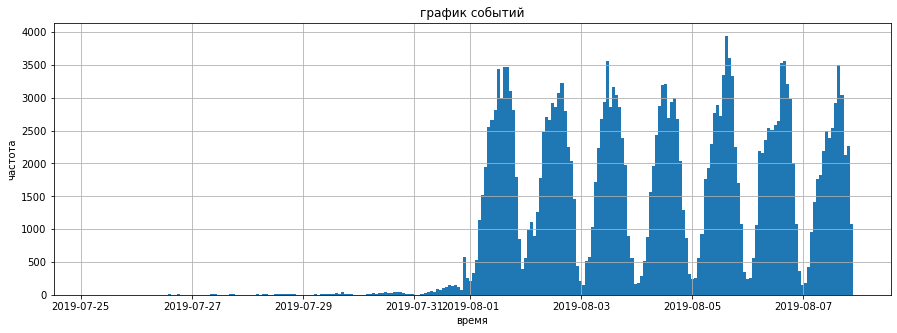

In [336]:
#Построим гистограмму по дате времени
df['event_date'].hist(bins = 250, figsize=(15,5))
plt.title("график событий")
plt.xlabel("время")
plt.ylabel("частота")
;

**Вывод:по графику мы видим что до 1 августа данные неполные, думаю, что стоит отсечь данные до этого дня, чтобы не учитывать возможные некорректные или неполные данные**


In [337]:
#изменим тип даты столбца 'date'
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  object        
 2   event_date  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.3+ MB


In [338]:
df[df['date'] > '2019-08-01']['event_name'].count()

204746

In [339]:
#проверим сколько данных мы потеряли за период который отсекли
dif = df['date'].count() - df[df['date'] > '2019-08-01']['date'].count()
dif

38967

In [340]:
df[df['date'] <= '2019-07-31'].groupby('date')[['device_id','event_name']].nunique().sum().to_frame()

,0
device_id,1492
event_name,31


In [341]:
#Отбросим старые данные
df = df[df['date'] > '2019-08-01']

проверим период данных после отброски ненужных дней

In [342]:
#проверим за какой период мы обладаем полноценными данными
days_actual = (df['event_date'].max()-df['event_date'].min())
days_actual

Timedelta('5 days 21:15:17')

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204746 entries, 38967 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  204746 non-null  object        
 1   device_id   204746 non-null  object        
 2   event_date  204746 non-null  datetime64[ns]
 3   group       204746 non-null  object        
 4   date        204746 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(3)
memory usage: 9.4+ MB


In [344]:
df['event_name'].count()

204746

## 4. Изучение воронки событий.

Посмотрим какие события есть в логах и как часто они встречаются

In [345]:
df1= df.pivot_table(index='event_name', values='device_id', aggfunc='nunique', sort=True).sort_values(by='device_id', ascending=False)
df1

,device_id
event_name,
MainScreenAppear,7156
OffersScreenAppear,4380
CartScreenAppear,3571
PaymentScreenSuccessful,3399
Tutorial,690


посмотрим доли по событиям

In [346]:
df['event_name'].value_counts(normalize = True).round(3).reset_index()

,index,event_name
0,MainScreenAppear,0.485
1,OffersScreenAppear,0.192
2,CartScreenAppear,0.176
3,PaymentScreenSuccessful,0.142
4,Tutorial,0.004


Думаю, что tutorial можно убрать из обработки так как это независимое редкое событие

In [347]:
df1 = df1[:4].copy()

In [348]:
df1

,device_id
event_name,
MainScreenAppear,7156
OffersScreenAppear,4380
CartScreenAppear,3571
PaymentScreenSuccessful,3399


посмотрим долю пользователей которые хоть раз совершали событие

In [349]:
df1['percent, %'] = round(df1['device_id']/df1['device_id'][0]*100)
df1

,device_id,"percent, %"
event_name,,
MainScreenAppear,7156,100.0
OffersScreenAppear,4380,61.0
CartScreenAppear,3571,50.0
PaymentScreenSuccessful,3399,47.0


Таким образом события происходят в следующем порядке:
1. Главный экран
2. экран с предложением
3. экран корзины
4. экран успешной оплаты

In [350]:
# Посчитаем какая доля выходит на следующий шаг воронки
df1['shift'] = df1['device_id'].shift(1)
df1

,device_id,"percent, %",shift
event_name,,,
MainScreenAppear,7156,100.0,NaN
OffersScreenAppear,4380,61.0,7156.0
CartScreenAppear,3571,50.0,4380.0
PaymentScreenSuccessful,3399,47.0,3571.0


In [351]:
df1['step'] = round(df1['device_id']/df1['shift']*100)
df1

,device_id,"percent, %",shift,step
event_name,,,,
MainScreenAppear,7156,100.0,NaN,NaN
OffersScreenAppear,4380,61.0,7156.0,61.0
CartScreenAppear,3571,50.0,4380.0,82.0
PaymentScreenSuccessful,3399,47.0,3571.0,95.0


Вывод больше всего пользователей теряется на первом шаге попосле просмотра главного экрана. 39%
От момента первого события до оплаты доходит 47% пользователей

## 5. Анализ результатов эксперимента

In [352]:
#посмотрим сколько всего пользователей в каждой экспериментальной группе
df[df['event_name'] == 'MainScreenAppear'].groupby('group').agg({'device_id': 'nunique'})

,device_id
group,
246,2355
247,2392
248,2409


In [353]:
df[df['event_name'] == 'PaymentScreenSuccessful'].groupby('group').agg({'device_id': 'nunique'})

,device_id
group,
246,1152
247,1118
248,1129


In [354]:
#Добавим объединенную группу '246+247'
funnels = df.pivot_table(index='event_name', columns='group',values='device_id',aggfunc='nunique')\
                       .sort_values('246',ascending=False)
funnels['246+247'] = funnels['246'] + funnels['247']
funnels.drop(['Tutorial'], inplace=True)
funnels

group,246,247,248,246+247
event_name,,,,
MainScreenAppear,2355,2392,2409,4747
OffersScreenAppear,1480,1438,1462,2918
CartScreenAppear,1213,1184,1174,2397
PaymentScreenSuccessful,1152,1118,1129,2270


In [355]:
#сделаем табличку для учета общего количества пользователей 
users = df.groupby('group')['device_id'].nunique().to_frame()
users

,device_id
group,
246,2393
247,2434
248,2459


In [356]:
#добавим строку с объединенной группой
users = users.reset_index()
users.loc[3] = ['246+247', 4827]
users = users.set_index(users.columns[0])
users

,device_id
group,
246,2393
247,2434
248,2459
246+247,4827


In [357]:
#Зададим функцию для нахождения статзначимости между сравниваемыми группами
def z_test(exp1, exp2, event, alpha): 
    p1_ev = funnels.loc[event, exp1]
    p2_ev = funnels.loc[event, exp2] 
    p1_us = users.loc[exp1, 'device_id'] 
    p2_us = users.loc[exp2, 'device_id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Найдем стат значимость между контрольными группами (246 и 247) по каждому шагу воронки.
H0 - группы не имеют статистически значимой разницы. H1- между группами есть статистически знаимая разница.
уровень стат значимости определим в Alpha = 0.05.

In [358]:
for event in funnels.index:
    z_test('246', '247', event, 0.05)
    print()

Проверка для  246 и 247, событие: MainScreenAppear, p-значение: 0.71
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: OffersScreenAppear, p-значение: 0.05
Отвергаем нулевую гипотезу

Проверка для  246 и 247, событие: CartScreenAppear, p-значение: 0.16
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 247, событие: PaymentScreenSuccessful, p-значение: 0.12
Не получилось отвергнуть нулевую гипотезу



**Вывод:
между контрольными группами на втором шаге  (экран предложения) воронки есть статистически значимая разница.**

Найдем стат значимость между контрольной группой 246 и экспериментальной 248 по каждому шагу воронки. Уровень стат значимости определим в Alpha =0.05.
Н0 - между группами нет статистически значимой разницы. Н1 - группы отличаются между собой.

In [359]:
for event in funnels.index:
    z_test('246', '248', event, 0.05)
    print()

Проверка для  246 и 248, событие: MainScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: OffersScreenAppear, p-значение: 0.09
Не получилось отвергнуть нулевую гипотезу

Проверка для  246 и 248, событие: CartScreenAppear, p-значение: 0.04
Отвергаем нулевую гипотезу

Проверка для  246 и 248, событие: PaymentScreenSuccessful, p-значение: 0.12
Не получилось отвергнуть нулевую гипотезу



**Вывод: между группами на третьем шаге воронки (экран корзины) есть статистически значимая разница.**

Найдем стат значимость между контрольной группой 247 и экспериментальной 248 по каждому шагу воронки. Уровень стат значимости определим в Alpha =0.05.
Н0 - между группами нет статистически значимой разницы. Н1 - группы отличаются между собой.

In [360]:
for event in funnels.index:
    z_test('247', '248', event, 0.05)
    print()

Проверка для  247 и 248, событие: MainScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: OffersScreenAppear, p-значение: 0.79
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: CartScreenAppear, p-значение: 0.53
Не получилось отвергнуть нулевую гипотезу

Проверка для  247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.99
Не получилось отвергнуть нулевую гипотезу



**Вывод: между сравниваемыми группами нет статистически значимой разницы.**

Найдем стат значимость между объединенной контрольной группой 246-247 и экспериментальной 248 по каждому шагу воронки. Уровень стат значимости определим в Alpha =0.05.
Н0 - между группами нет статистически значимой разницы. Н1 - группы отличаются между собой.

In [361]:
for event in funnels.index:
    z_test('246+247', '248', event, 0.05)
    print()

Проверка для  246+247 и 248, событие: MainScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: OffersScreenAppear, p-значение: 0.41
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: CartScreenAppear, p-значение: 0.12
Не получилось отвергнуть нулевую гипотезу

Проверка для  246+247 и 248, событие: PaymentScreenSuccessful, p-значение: 0.37
Не получилось отвергнуть нулевую гипотезу



**Вывод: между сравниваемыми группами нет статистически значимой разницы**

## 6. Общий вывод.

В результате  исследования мы провели 4 **АА** теста и 12 **АВ** тестов. Критерий значимости установили на уровне 0,05. Не вижу смысла делать критерий в 0,01 так как по резульататм теста видно, что и с критерием 0,05 все видно. 
Итак по результатам тестирования видно что статистически значимой разницы между контрольными группами и экспериментальной нет, немного смущает разница между контрольными группами на втором шаге воронки, но я думаю, что тут важнее сомтреть на конверсию в первый шаг и в шаг оплаты, так как они являются наиболее показательными и соответствуют целям бизнеса. можно добиться крутой конверсии в шаг, но если конверсия в покупку остается неизменной, то назвать такую работу эффективной не получится. Поэтому считаю, что эксперимент можно признать неудачным и переходить к проверке других гипотез.